In [1]:
# user-friendly print
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.instance().ast_node_interactivity = "all"

In [2]:
import lightning as L
import torch
import torch.nn as nn
from numpy import ndarray

torch.set_float32_matmul_precision("medium")  # 推荐选项


class _DilatedTCN(nn.Module):
    """Simple 1-D Dilated TCN block stack with residual connections."""

    def __init__(self, channels: int, n_layers: int = 4, kernel_size: int = 3):
        super().__init__()
        # 自动调整kernel_size为最近的奇数
        if kernel_size % 2 == 0:
            print(f"Warning: kernel_size={kernel_size} is even, automatically changed to {kernel_size + 1}")
            kernel_size += 1
        dilations = [2**i for i in range(n_layers)]
        pads = [((kernel_size - 1) * d) // 2 for d in dilations]
        self.layers = nn.ModuleList(
            [
                nn.Conv1d(
                    channels,
                    channels,
                    kernel_size,
                    dilation=d,
                    padding=p,
                )
                for d, p in zip(dilations, pads)
            ]
        )
        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x : torch.Tensor
            Input tensor, shape (B, C, L).

        Returns
        -------
        torch.Tensor
            Output tensor, shape (B, C, L).
        """
        # x: (B,C,L)
        out = x
        for conv in self.layers:
            res = out
            out = self.act(conv(out))
            out = out + res
        return out


class SequenceHeadTCNFiLM(nn.Module):
    """
    Dilated-TCN + FiLM modulation sequence head for Lightning.

    Parameters
    ----------
    d_in : int
        Input descriptor dimension.
    hidden : int
        Hidden dimension for TCN and projections.
    n_layers : int
        Number of TCN layers.
    kernel_size : int
        Kernel size for TCN.
    """

    def __init__(self, d_in: int, hidden: int = 128, n_layers: int = 4, kernel_size: int = 3):
        super().__init__()
        self.temp_proj = nn.Linear(1, hidden)
        self.tcn = _DilatedTCN(hidden, n_layers=n_layers, kernel_size=kernel_size)
        self.film = nn.Linear(d_in, 2 * hidden)
        self.out = nn.Linear(hidden, 1)

    def forward(self, temps: torch.Tensor, h: torch.Tensor) -> torch.Tensor:
        # temps: (B, L, 1) -> x: (B, hidden, L)
        x = self.temp_proj(temps).permute(0, 2, 1)
        x = self.tcn(x)
        x = x.permute(0, 2, 1)
        gamma, beta = self.film(h).unsqueeze(1).chunk(2, dim=-1)
        fused = gamma * x + beta
        y = self.out(fused)
        return y

    def _predict_impl(self, x: torch.Tensor, additional: bool = False) -> dict[str, ndarray]:
        return {"values": x.cpu().numpy()}


class LightningTCNFiLM(L.LightningModule):
    def __init__(self, d_in, hidden=128, n_layers=4, kernel_size=3, lr=1e-3, loss_fn=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = SequenceHeadTCNFiLM(d_in, hidden, n_layers, kernel_size)
        self.lr = lr
        self.loss_fn = loss_fn if loss_fn is not None else nn.MSELoss()

    def forward(self, temps, h):
        return self.model(temps, h)

    def training_step(self, batch, batch_idx):
        temps, h, target = batch
        pred = self(temps, h)
        assert pred.shape == target.shape, f"pred shape {pred.shape}, target shape {target.shape}"
        temps, h, target = batch
        pred = self(temps, h)
        loss = self.loss_fn(pred, target)
        self.log("train/loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        temps, h, target = batch
        pred = self(temps, h)
        loss = self.loss_fn(pred, target)
        self.log("val/loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        temps, h, target = batch
        pred = self(temps, h)
        loss = self.loss_fn(pred, target)
        self.log("test/loss", loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        temps, h, target = batch
        pred = self(temps, h)
        assert pred.shape == target.shape, f"pred shape {pred.shape}, target shape {target.shape}"
        return temps, target, pred

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [3]:
from typing import Tuple

import pandas as pd
import torch
from torch.utils.data import Dataset


class DOSDataset(Dataset):
    def __init__(self, desc: pd.DataFrame, dos_energy: pd.Series, dos: pd.Series):
        super().__init__()
        self.desc = desc
        self.dos_energy = dos_energy
        self.dos = dos
        # 只保留索引交集的样本
        common_idx = desc.index.intersection(dos.index).intersection(dos_energy.index)
        self.indices: list = list(common_idx)
        self.d_descriptor: int = desc.shape[1]

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        key = self.indices[idx]
        descriptor = torch.tensor(self.desc.loc[key].values, dtype=torch.float32)
        energy_grid = torch.tensor(self.dos_energy.loc[key], dtype=torch.float32).unsqueeze(-1)  # (L, 1)
        dos_curve = torch.tensor(self.dos.loc[key], dtype=torch.float32).unsqueeze(-1)  # (L, 1)
        return energy_grid, descriptor, dos_curve

In [4]:
from typing import Optional

import lightning as pl
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader


class DOSDataModule(pl.LightningDataModule):
    def __init__(
        self,
        desc: pd.DataFrame,
        dos_energy: pd.Series,
        dos: pd.Series,
        serial: Optional[pd.Series] = None,  # index->"train"/"val"/"test"
        batch_size: int = 32,
        random_seed: int = 42,
    ):
        super().__init__()
        self.desc = desc
        self.dos_energy = dos_energy
        self.dos = dos
        self.serial = serial
        self.batch_size = batch_size
        self.random_seed = random_seed

    def setup(self, stage=None):
        if self.serial is not None:
            train_idx = self.serial[self.serial == "train"].index
            val_idx = self.serial[self.serial == "val"].index
            test_idx = self.serial[self.serial == "test"].index
        else:
            # 自动划分
            all_idx = np.array(list(self.desc.index.intersection(self.dos.index).intersection(self.dos_energy.index)))
            rng = np.random.RandomState(self.random_seed)
            perm = rng.permutation(len(all_idx))
            n = len(all_idx)
            n_train = int(n * 0.7)
            n_val = int(n * 0.1)
            # n_test = n - n_train - n_val  # 未被使用，可删除
            train_idx = all_idx[perm[:n_train]]
            val_idx = all_idx[perm[n_train : n_train + n_val]]
            test_idx = all_idx[perm[n_train + n_val :]]
        self.train_dataset = DOSDataset(
            self.desc.loc[train_idx], self.dos_energy.loc[train_idx], self.dos.loc[train_idx]
        )
        self.val_dataset = DOSDataset(self.desc.loc[val_idx], self.dos_energy.loc[val_idx], self.dos.loc[val_idx])
        self.test_dataset = DOSDataset(self.desc.loc[test_idx], self.dos_energy.loc[test_idx], self.dos.loc[test_idx])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [5]:
import random

import matplotlib.pyplot as plt
import torch


def plot_prediction_pairs(samples, *, n=9, seed=42, prop="", title_prefix="Sample", show_true=True, show_pred=True):
    """
    输入 samples: List of (t, v_true) 或 (t, v_true, v_pred)
    自动判断有无 pred，进行单曲线或对比绘图
    只取每条曲线中间90%的数据进行绘制
    show_true: 是否绘制真实曲线
    show_pred: 是否绘制预测曲线
    额外输出本次抽中的indices
    """
    random.seed(seed)  # 固定随机种子以确保可重复性

    indices = random.sample(range(len(samples)), n)
    print("plot_prediction_pairs indices:", indices)  # 输出抽中的indices
    n_cols = int(np.sqrt(n))
    n_rows = int(np.ceil(n / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3 * n_rows))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        entry = samples[idx]
        if len(entry) == 2:
            t, v_true = entry
            v_pred = None
        elif len(entry) == 3:
            t, v_true, v_pred = entry
        else:
            raise ValueError("Each sample must be (t, v_true) or (t, v_true, v_pred)")

        t = t.squeeze(-1).cpu().numpy()
        v_true = v_true.squeeze(-1).cpu().numpy()
        n_points = len(t)
        start = int(n_points * 0.05)
        end = int(n_points * 0.95)
        t_mid = t[start:end]
        v_true_mid = v_true[start:end]

        ax = axes[i]
        if show_true:
            ax.plot(t_mid, v_true_mid, label="True", linewidth=1.5)
        if show_pred and v_pred is not None:
            v_pred = v_pred.squeeze(-1).cpu().numpy()
            v_pred_mid = v_pred[start:end]
            ax.plot(t_mid, v_pred_mid, label="Pred", linewidth=1.5)
        ax.set_title(f"{title_prefix} #{idx}")
        ax.set_xlabel("Temperature (K)")
        ax.set_ylabel(prop)
        ax.legend()

    for j in range(n, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [6]:
import joblib
import pandas as pd
from pymatgen.core import Composition

preprocessing_objects = joblib.load("/data/foundation_model/data/preprocessing_objects_20250529.pkl.z")
qc_ac_te_mp_dos_data = pd.read_parquet("/data/foundation_model/data/qc_ac_te_mp_dos_reformat_20250529.pd.parquet")
qc_ac_te_mp_dos_data = qc_ac_te_mp_dos_data.loc[~qc_ac_te_mp_dos_data.index.isin(preprocessing_objects["dropped_idx"])]
qc_ac_te_mp_dos_data.composition = qc_ac_te_mp_dos_data.composition.apply(
    lambda x: Composition({k: v for k, v in x.items() if v is not None and v > 0})
)
desc_trans = pd.read_parquet("/data/foundation_model/data/qc_ac_te_mp_dos_composition_desc_trans_20250529.pd.parquet")

In [7]:
_ = [
    "Thermal conductivity",  # 0
    "Electrical resistivity",  # 1
    "Power factor",  # 2
    "Seebeck coefficient",  # 3
    "ZT",  # 4
    "Magnetic susceptibility",  # 5
    "DOS density",  # 6
]

prop = _[6]

prop_value = qc_ac_te_mp_dos_data[prop].dropna()
prop_value_norm = qc_ac_te_mp_dos_data[f"{prop} (normalized)"].loc[prop_value.index]
prop_T = (
    qc_ac_te_mp_dos_data[f"{prop} (T/K)"].loc[prop_value.index]
    if prop != "DOS density"
    else qc_ac_te_mp_dos_data["DOS energy"].loc[prop_value.index]
)
desc = desc_trans.loc[prop_value.index]
split = qc_ac_te_mp_dos_data["split"].loc[prop_value.index]

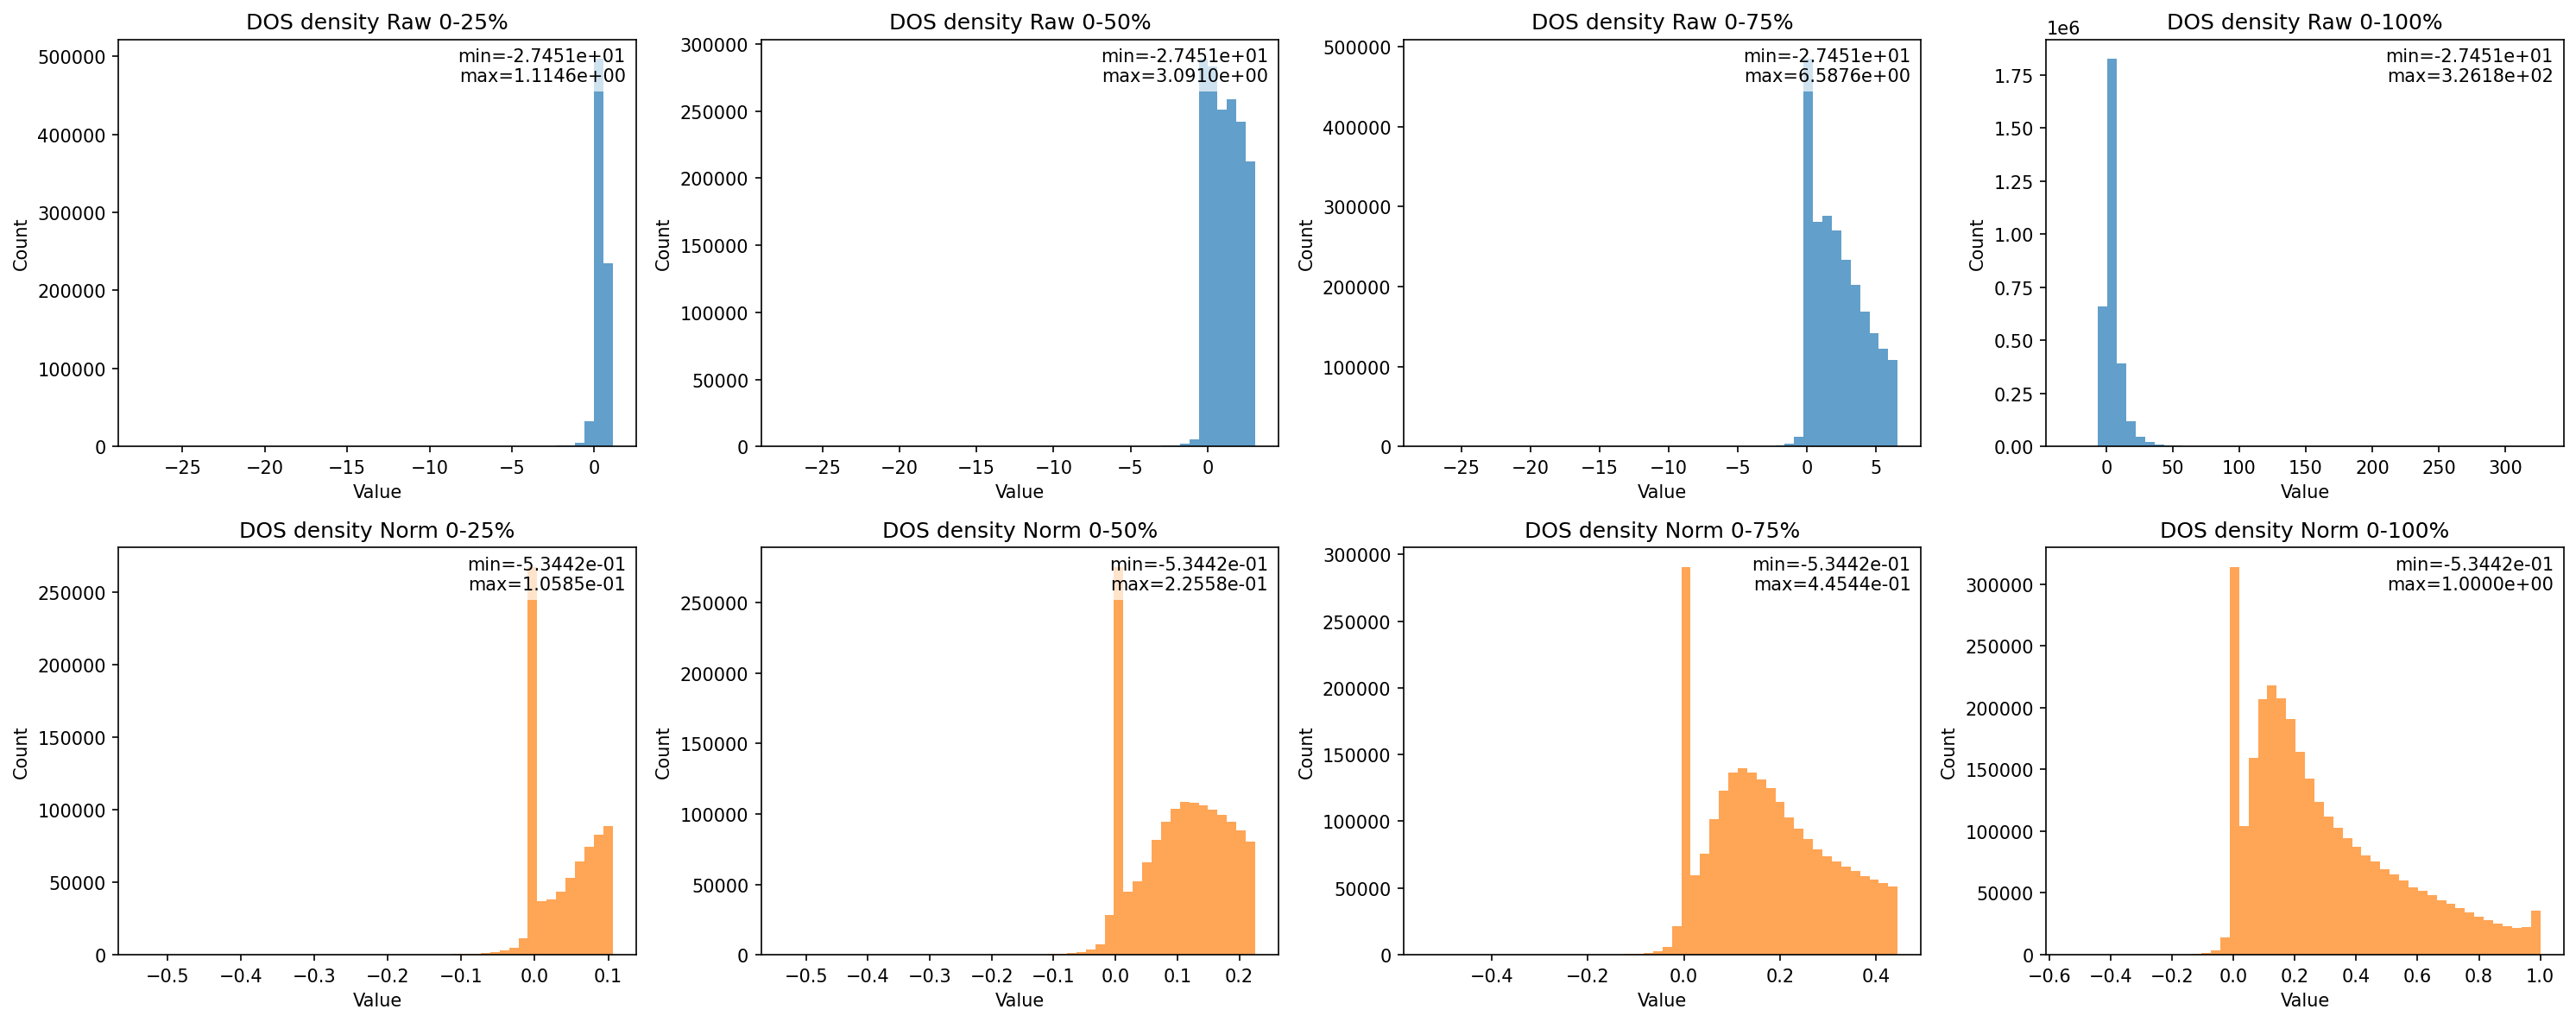

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), dpi=150)
percentiles = [0.25, 0.5, 0.75, 1.0]
titles = ["0-25%", "0-50%", "0-75%", "0-100%"]

for row, data_series in enumerate([prop_value, prop_value_norm]):
    a = np.concatenate([i for i in data_series])
    a_sorted = np.sort(a)
    n = len(a_sorted)
    for col, p in enumerate(percentiles):
        end = int(n * p)
        data_slice = a_sorted[:end]
        ax = axes[row, col]
        _ = ax.hist(data_slice, bins=50, color="C0" if row == 0 else "C1", alpha=0.7)
        min_val, max_val = data_slice.min(), data_slice.max()
        _ = ax.set_title(f"{prop} {'Raw' if row == 0 else 'Norm'} {titles[col]}")
        _ = ax.text(
            0.98,
            0.98,
            f"min={min_val:.4e}\nmax={max_val:.4e}",
            ha="right",
            va="top",
            transform=ax.transAxes,
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )
        _ = ax.set_xlabel("Value")
        _ = ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | SequenceHeadTCNFiLM | 2.1 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.428     Total estimated model params size (MB)


Epoch 0:  19%|█▉        | 22/113 [00:00<00:01, 65.38it/s, v_num=5, train/loss_step=70.50] 

Epoch 14: 100%|██████████| 113/113 [00:01<00:00, 64.21it/s, v_num=5, train/loss_step=30.30, val/loss=42.30, train/loss_epoch=36.50]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 113/113 [00:01<00:00, 62.39it/s, v_num=5, train/loss_step=30.30, val/loss=42.30, train/loss_epoch=36.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 171.78it/s]
plot_prediction_pairs indices: [298, 941, 931, 1578, 357, 1444, 804, 1499, 716]


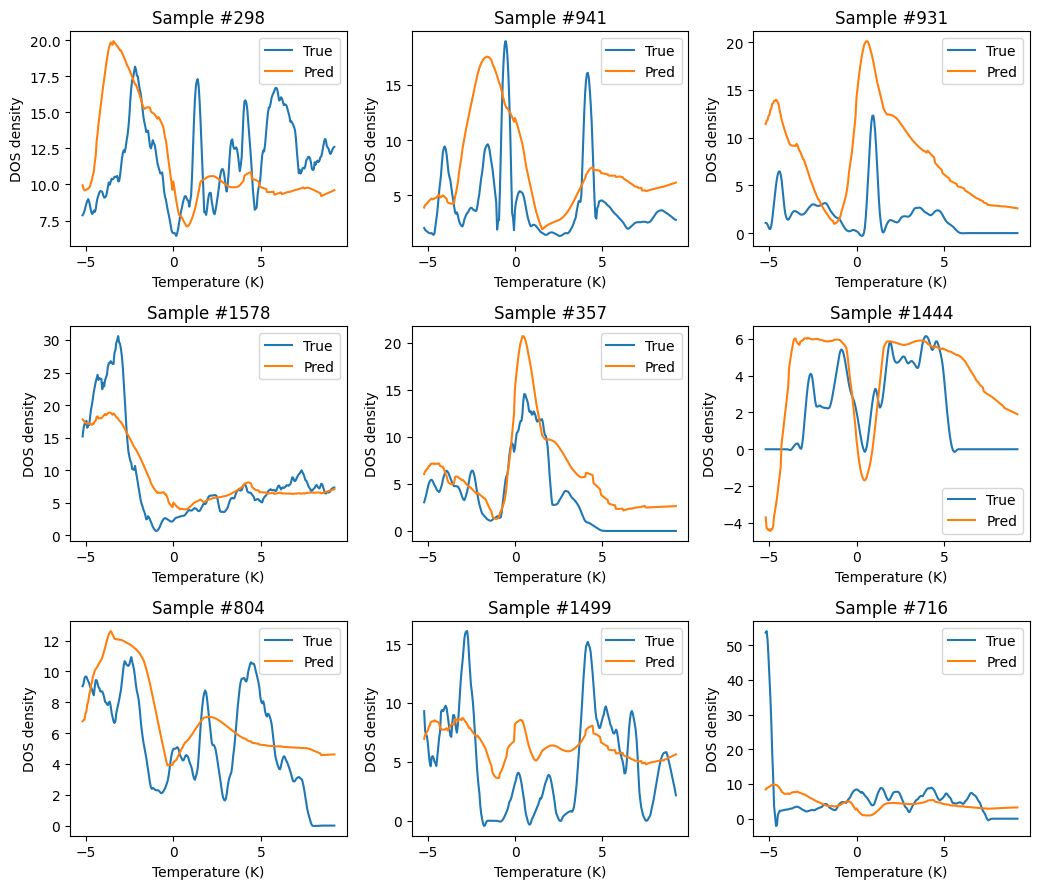

In [11]:
from lightning import Trainer
from lightning.pytorch.callbacks import EarlyStopping

# 1. 初始化数据模块
dm = DOSDataModule(
    desc=desc,
    dos_energy=prop_T,
    dos=prop_value,
    serial=split,
    batch_size=64,
    random_seed=42,
)
dm.setup()

# 2. 初始化模型
model = LightningTCNFiLM(
    d_in=desc.shape[1],
    hidden=128,
    n_layers=4,
    kernel_size=30,
    lr=1e-3,
)

# 3. 初始化训练器
trainer = Trainer(
    max_epochs=15,
    accelerator="auto",
    callbacks=[EarlyStopping(monitor="val/loss", patience=5, mode="min")],
    log_every_n_steps=100,
)

# 4. 开始训练
trainer.fit(model, datamodule=dm)

# 5. predict
preds = trainer.predict(model, dataloaders=dm.test_dataloader())

# 6. 可视化预测结果
# flatten and pass to plot
samples = [sample for batch in preds for sample in zip(*batch)]
plot_prediction_pairs(samples, n=9, prop=prop, seed=100, show_pred=True)